In [25]:
import torch
from torch.utils.data import Dataset, DataLoader
from glob import glob
import os
import pandas as pd
import cv2
import pickle
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import numpy as np
import matplotlib.pyplot as plt

In [26]:
class OpenImageDataset(Dataset):
    def __init__(self, df, labelfile,  transform=None):
        self.df = df
        self.transform = transform
        self.images = glob('train_0/*.jpg')
        self.labelmap = labelfile

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        image = cv2.imread(img)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        #img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # diving by 255
        image /= 255.0
        h, w, c = image.shape

        # getting index of image to find annotations
        img_idx = img.split('.')[0].split('/')[1]

        annot_df = self.df.loc[self.df['ImageID']==img_idx]

        # list of annotations
        XMin = annot_df['XMin'].to_list()
        XMax = annot_df['XMax'].to_list()
        YMin = annot_df['YMin'].to_list()
        YMax = annot_df['YMax'].to_list()

        labels = annot_df['LabelName'].to_list()
        # numericalize
        labels = [self.labelmap[lbl] for lbl in labels]
        labels = torch.as_tensor(labels, dtype=torch.int64)

        boxes = [[int(xmin*w), int(ymin*h), int(xmax*w), int(ymax*h)] for
                 xmin, ymin, xmax, ymax in zip(XMin, YMin, XMax, YMax)]

        boxes = torch.as_tensor(boxes, dtype=torch.float32)


        area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 1] - boxes[:, 3])
        is_crowd = torch.zeros((boxes.shape[0], ), dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['area'] = area
        target['iscrowd'] = is_crowd
        target['imageid'] = torch.tensor([idx])


        if self.transform:
            num_boxes = len(target['boxes'])
            sample = self.transform(image=image, bboxes=target['boxes'], labels=labels)
            image = sample['image']
            target['boxes'] = torch.tensor(sample['bboxes'])
        return image, target


In [27]:
# Send train=True fro training transforms and False for val/test transforms
def get_transform(train):

    if train:
        return A.Compose([
                            A.HorizontalFlip(),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2()
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2()
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [28]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def plot_annotations_with_matplotlib(image, annotations, label_map=None):
    """
    Plots bounding boxes on the image using matplotlib.
    
    Parameters:
    - image (numpy.ndarray): The image to be plotted.
    - annotations (dict): A dictionary containing the annotations (boxes and labels).
    - label_map (dict, optional): A mapping from numerical labels to string labels.
    """
    
    fig, ax = plt.subplots(1, figsize=(12,9))
    ax.imshow(image)
    
    # Iterate through each bounding box
    for box, label in zip(annotations['boxes'], annotations['labels']):
        # Convert tensor box to numpy for processing
        box = box.cpu().numpy().astype(np.int32)
        
        # Create a rectangle patch
        rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor='r', facecolor='none')
        
        # Get the label text
        if label_map:
            label_text = label_map[label.item()]
        else:
            label_text = str(label.item())
        
        # Display the label text above the bounding box
        plt.text(box[0], box[1], label_text, bbox=dict(facecolor='blue', alpha=0.5), fontsize=12, color='white')
        
        # Add the rectangle to the axes
        ax.add_patch(rect)
    
    plt.axis('off')
    plt.show()


In [11]:
# root_dir = os.getcwd()
# df = pd.read_csv('train-annotations-bbox.csv')
# #labels = df['LabelName'].unique()
# #print(f"number of unique labels are {len(labels)}")
# #labeldict = {idx: label for idx, label in enumerate(labels)}
# #labeldictr = {label: idx for idx, label in labeldict.items()}
# #with open('labelmap.pkl', 'wb') as f:
# #    pickle.dump(labeldictr, f)
# with open('labelmap.pkl', 'rb') as f:
#     labelmap = pickle.load(f)
# ds = OpenImageDataset(df, labelmap, transform=get_transform(train=True))

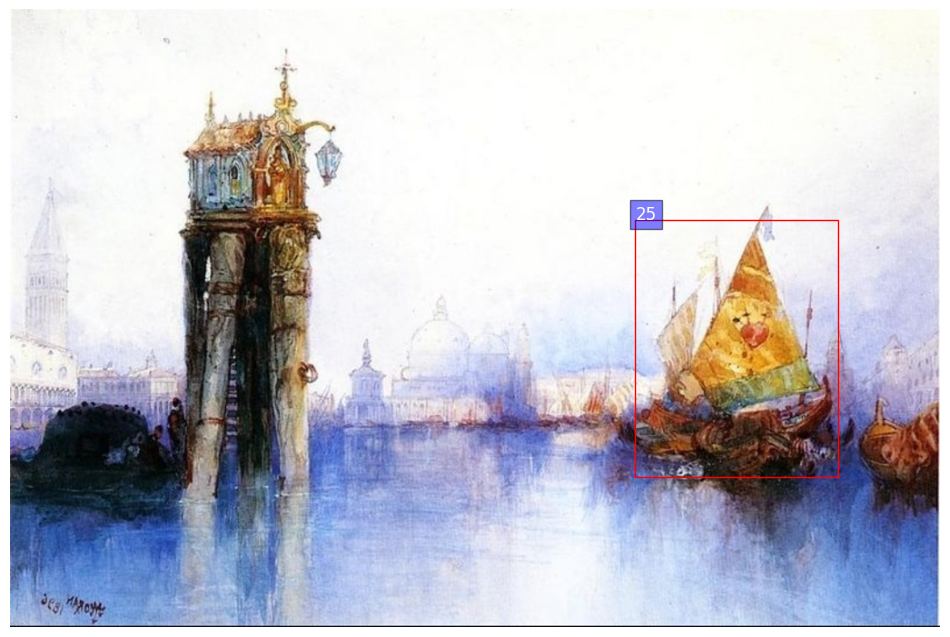

In [29]:
# Assuming ds is your dataset
import random
idx = random.randint(0, len(ds))
image_tensor, target = ds[idx]
# Convert image tensor to numpy array and rearrange channels
image_numpy = image_tensor.cpu().numpy().transpose(1,2,0)

plot_annotations_with_matplotlib(image_numpy, target)

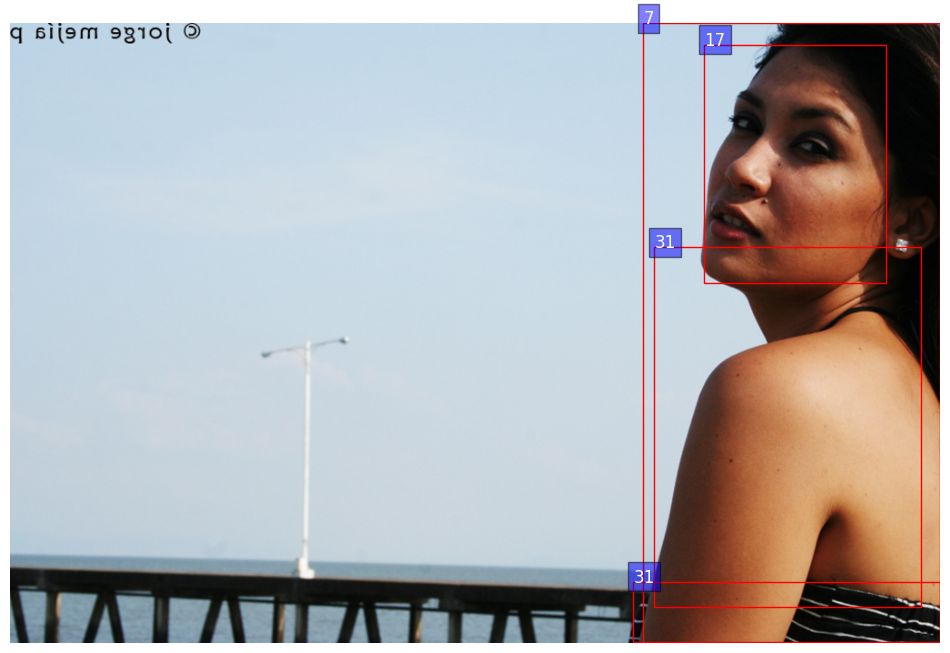

In [30]:
# Assuming ds is your dataset
import random
idx = random.randint(0, len(ds))
image_tensor, target = ds[idx]
# Convert image tensor to numpy array and rearrange channels
image_numpy = image_tensor.cpu().numpy().transpose(1,2,0)

plot_annotations_with_matplotlib(image_numpy, target)